<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr). 

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

#### Generate Data

First lets generate some data. Using the package trdg at this repo [https://github.com/hezarai/trdg-persian](https://github.com/hezarai/trdg-persian) generate a 
tiny 1 million text images. The preferred command is below:


In [1]:
%%bash
repo_name="trdg-persian"
repo_url="https://github.com/hezarai/$repo_name.git"

# Check if the repo exists
if [ ! -d "$repo_name" ]; then
  # Clone the repo if it doesn't exist
  git clone "$repo_url"
else
  # Pull the latest changes if the repo exists
  cd "$repo_name"
  git pull
fi

Already up to date.


In [9]:
# install libfreetype6-dev
# sudo apt-get -y install libfreetype6-dev
# close terminal and open notebook again!

IndentationError: unexpected indent (2722222583.py, line 5)

In [1]:
!pip install -q transformers datasets jiwer
!pip uninstall -y pillow
!pip install --no-cache-dir pillow==8.3.2
!pip install -U trdg-persian/

Found existing installation: Pillow 8.3.2
Uninstalling Pillow-8.3.2:
  Successfully uninstalled Pillow-8.3.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 MB 519.9 kB/s eta 0:00:0000:0100:03
  Preparing metadata (setup.py) ... done
  Created wheel for pillow: filename=Pillow-8.3.2-cp311-cp311-linux_x86_64.whl size=511712 sha256=a527b6f92e21747586041beeb21c0e3aa311b77a6e3695fe0371afc720ff70f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-tgdmuc3v/wheels/b7/42/63/77ac30adf908e40326191e7134909628bb6e242aac46e749b4
Successfully built pillow
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.21.0 requires pillow>=9.0.1, but you have pillow 8.3.2 which is incompatible.
hezar 0.23.1 requires transformers==4.30.2, but you have transformers 4.32.0.dev0 which is incompatible.
pyrlottie 2022.0.2 requires attrs<22,>=21.4.0, but you have attrs 23.1.

In [7]:
!rm -rf outputs/

In [8]:
!trdg --output_dir ./outputs/bw -l fa -fd trdg-persian/trdg/fonts/fa --dict trdg-persian/trdg/dicts/lscp-raw-1m.txt -t 48 -c 1000000 -w 1 -bl 0 -rbl -m 3,3,3,3 -tc "#284854,#542828" -k 5 -rk -na 1 -ws -b 0 -f 48

Missing modules for handwritten text generation.
100%|████████████████████████████████| 1000000/1000000 [18:35<00:00, 896.18it/s]


Then you have to move the outputs folder (`./outputs/bw`) to `data/bw` in this folder.

Now lets do the actual job.

### Read Dataset

In [1]:
import os

import pandas as pd

In [2]:
data_path = "outputs/bw"  # PROVIDE THE RIGHT PATH TO IMAGE DATA FOLDER
encoder_path = "google/vit-base-patch16-224-in21k"
decoder_path = "HooshvareLab/roberta-fa-zwnj-base"

#### Generate image/text pairs dataframe

In [3]:
paths = []
labels = []
for f in os.listdir(data_path):
    label = f.split("_")[1].split(".")[0]
    paths.append(f)
    labels.append(label)

In [4]:
df = pd.DataFrame({"file_name": paths, "text": labels})

In [5]:
df.head()

,file_name,text
0,66053_ خبرنگار ترکش خمپاره پیشونیش رو چاک داده...,خبرنگار ترکش خمپاره پیشونیش رو چاک داده بود
1,860015_ بازی دادن مرگ آسون میشهوقتی با لبخند م...,بازی دادن مرگ آسون میشهوقتی با لبخند میجنگیم
2,861256_ یاد مردای توی زورخونه میافتم.jpg,یاد مردای توی زورخونه میافتم
3,65241_ خبرنگار ترکش خمپاره پیشونیش رو چاک داده...,خبرنگار ترکش خمپاره پیشونیش رو چاک داده بود
4,573631_ خبرنگار ترکش خمپاره پیشونیش رو چاک داد...,خبرنگار ترکش خمپاره پیشونیش رو چاک داده بود


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998701 entries, 0 to 998700
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   file_name  998701 non-null  object
 1   text       998701 non-null  object
dtypes: object(2)
memory usage: 15.2+ MB


We split up the data into training + testing, using sklearn's `train_test_split` function.

#### Train/Test split

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

### Dataset Class

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image


class LSCPSynthDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128, h_flip=True):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.h_flip = h_flip

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df["file_name"][idx]
        text = self.df["text"][idx]
        # prepare image (i.e. resize + normalize)
        image_path = os.path.join(self.root_dir, file_name)
        image = Image.open(image_path).convert("RGB")
        if self.h_flip:
            image.transpose(Image.FLIP_LEFT_RIGHT)
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, padding="max_length", max_length=self.max_target_length, 
        ).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100
            for label in labels]
        labels = torch.tensor(labels)
        
        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "labels": labels,
        }
        return encoding

Let's initialize the training and evaluation datasets:

In [9]:
from transformers import TrOCRProcessor, AutoTokenizer

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1", size=224)
tokenizer = AutoTokenizer.from_pretrained(decoder_path)
processor.tokenizer = tokenizer
train_dataset = LSCPSynthDataset(root_dir=data_path, df=train_df, processor=processor)
eval_dataset = LSCPSynthDataset(root_dir=data_path, df=test_df, processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [10]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 798960
Number of validation examples: 199741


Let's verify an example from the training dataset:

In [13]:
image, labels = list(train_dataset[0].values())
print(image.shape, labels.shape)

torch.Size([3, 224, 224]) torch.Size([128])


We can also check the original image and decode the labels:

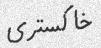

In [14]:
image = Image.open(os.path.join(train_dataset.root_dir, train_df['file_name'][0])).convert("RGB")
image

In [15]:
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

 خاکستری


## Collator

In [16]:
def data_collator(features):
    tokenizer.model_input_names = ["labels"]
    features = tokenizer.pad(
            features,
            padding="longest",
            return_tensors="pt",
        )
    return features

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [17]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder_path, decoder_path)

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at HooshvareLab/roberta-fa-zwnj-base and are newly initialized: ['roberta.encoder.layer.8.crossattention.output.dense.bias', 'roberta.encoder.layer.10.crossattention.self.value.weight', 'roberta.encoder.layer.10.crossattention.self.key.bias', 'roberta.encoder.layer.4.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.11.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.7.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.2.crossattention.self.value.bias', 'roberta.encoder.layer.3.crossattention.output.dense.bias', 'roberta.encoder.layer.2.crossattention.self.value.weight', 'roberta.encoder.layer.8.crossattention.self.value.bias', 'roberta.encoder.layer.8.crossattention.self.key.weight', 'roberta.encoder.layer.8.crossattention.self.key.bias', 'roberta.encoder.layer.6.crossattention.self.query.bias', 'rob

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [18]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [19]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=8,
    fp16=True,
    report_to=None,
    output_dir="./",
    logging_steps=100,
    save_steps=25000,
    eval_steps=25000,
)

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [20]:
from datasets import load_metric

cer_metric = load_metric("cer")

/tmp/ipykernel_41942/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [21]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)
trainer.train()

/home/ai/miniconda3/envs/py_3.11/lib/python3.11/site-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss
